# ML GROUP PROJECT

#### Group 1

Alexander Beck<br>
Joel Blank<br>
Pascal Müntener<br>
Arthur Pavlics<br>
Kenan Öztürk

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


#NEURAL NET
from tensorflow import keras
from tensorflow.keras import layers

#DECISION TREES
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


2023-04-06 16:02:06.494030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 16:02:06.658800: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-06 16:02:06.658821: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-06 16:02:07.419335: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-


# Data Cleaning
The Decision about which features we use is based on educated guesses about which features are predicitive of price and which ones are not. 'GrLivArea' will be much more prdictive of price than 'Heating', especially because 'Heating' is 'GasA' for almost all entries.<br><br>
We considered correlations between the features. 'FireplaceQu' correlates heavily with 'Fireplaces', because when there are no Fireplaces, the Fireplace quality is NaN. We have a similar relationship between GarageSize and GarageCars.<br><br>
The dataset's structure was also considered in feature selection. There are very few homes with pools. Any machine learning algorithm will have trouble learning much from those datapoints. Hence, such a feature is not included. Another example is the feature 'street', which is almost exclusively 'pave' with very few 'gravel' entries.

## Categorical data
- Use one-hot encoding.



In [2]:
#READ DATA AND SELECT FEATURES
data = pd.read_csv('./GroupProjectDataSet.csv', header=0, index_col=0)

DUMMIES = ['MSSubClass', 'MSZoning', 'LotConfig', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'MoSold', 'SaleCondition', 'BldgType', 'HouseStyle', 'SaleCondition']

dummies = pd.get_dummies(data[DUMMIES].astype(str)) #will be used later

print('Number of nan in dummies:', data[DUMMIES].isna().sum().sum())

Number of nan in dummies: 0


## Numerical data
- Add composite features.
- Scale all numericals.
- Convert strings to numbers.

The code could be written much more elegantly, but as it is written we can see easily what it is doing.

In [3]:
#add a composite feature that includes the age of the building when it was sold
data['AgeWhenSold'] = data['YrSold'] - data['YearBuilt']
#add a composite feature that includes the age of the building since last renovation when it was sold
data['AgeSinceRemod'] = data['YrSold'] - data['YearRemodAdd']

#scale to numbers to be between 0 and 2
#the choice of 2 is more or less arbitrary
#we tried 1, 2, 5, and 10. it does not impact model performance at all.
high = 2
data['GrLivArea'] = data['GrLivArea'] / data['GrLivArea'].max() * high
data['TotalBsmtSF'] = data['TotalBsmtSF'] / data['TotalBsmtSF'].max() * high
data['LotArea'] = data['LotArea'] / data['LotArea'].max() * high
data['AgeWhenSold'] = data['AgeWhenSold'] / data['AgeWhenSold'].max() * high
data['AgeSinceRemod'] = data['AgeSinceRemod'] / data['AgeSinceRemod'].max() * high
data['2ndFlrSF'] = data['2ndFlrSF'] / data['2ndFlrSF'].max() * high
data['BsmtFinSF1'] = data['BsmtFinSF1'] / data['BsmtFinSF1'].max() * high
data['OverallQual'] = data['OverallQual'] / data['OverallQual'].max() * high
data['OverallCond'] = data['OverallCond'] / data['OverallCond'].max() * high
data['BedroomAbvGr'] = data['BedroomAbvGr'] / data['BedroomAbvGr'].max() * high
data['GarageCars'] = data['GarageCars'] / data['GarageCars'].max() * high

#exterqual is given as strings 'Ex', 'TA' etc. we want to convert that to a number,
#because excellent is always better than average
#NOTE: this could be solved more elegantly since 'Ex', 'Gd' etc. are the same across the entire dataset, 
#one could replace them globally instead of for each column separately.
data['ExterQual'] = data['ExterQual'].replace('Ex', 5) 
data['ExterQual'] = data['ExterQual'].replace('Gd', 4) 
data['ExterQual'] = data['ExterQual'].replace('TA', 3) 
data['ExterQual'] = data['ExterQual'].replace('Fa', 2) 
data['ExterQual'] = data['ExterQual'].replace('Po', 1) 
data['ExterQual'] = data['ExterQual'] / data['ExterQual'].max() * high
#same for extercond
data['ExterCond'] = data['ExterCond'].replace('Ex', 5) 
data['ExterCond'] = data['ExterCond'].replace('Gd', 4) 
data['ExterCond'] = data['ExterCond'].replace('TA', 3) 
data['ExterCond'] = data['ExterCond'].replace('Fa', 2) 
data['ExterCond'] = data['ExterCond'].replace('Po', 1) 
data['ExterCond'] = data['ExterCond'] / data['ExterCond'].max() * high
#and bsmtqual
data['BsmtQual'] = data['BsmtQual'].fillna('NoBasement') #nan does not mean no value here
data['BsmtQual'] = data['BsmtQual'].replace('Ex', 5) 
data['BsmtQual'] = data['BsmtQual'].replace('Gd', 4) 
data['BsmtQual'] = data['BsmtQual'].replace('TA', 3) 
data['BsmtQual'] = data['BsmtQual'].replace('Fa', 2) 
data['BsmtQual'] = data['BsmtQual'].replace('Po', 1) 
data['BsmtQual'] = data['BsmtQual'].replace('NoBasement', 0) 
data['BsmtQual'] = data['BsmtQual'] / data['BsmtQual'].max() * high
#and heatingQC
data['HeatingQC'] = data['HeatingQC'].replace('Ex', 5) 
data['HeatingQC'] = data['HeatingQC'].replace('Gd', 4) 
data['HeatingQC'] = data['HeatingQC'].replace('TA', 3) 
data['HeatingQC'] = data['HeatingQC'].replace('Fa', 2) 
data['HeatingQC'] = data['HeatingQC'].replace('Po', 1) 
data['HeatingQC'] = data['HeatingQC'] / data['HeatingQC'].max() * high
#and kitchenqual
data['KitchenQual'] = data['KitchenQual'].replace('Ex', 5) 
data['KitchenQual'] = data['KitchenQual'].replace('Gd', 4) 
data['KitchenQual'] = data['KitchenQual'].replace('TA', 3) 
data['KitchenQual'] = data['KitchenQual'].replace('Fa', 2) 
data['KitchenQual'] = data['KitchenQual'].replace('Po', 1) 
data['KitchenQual'] = data['KitchenQual'] / data['KitchenQual'].max() * high
#and fireplacequ
data['FireplaceQu'] = data['FireplaceQu'].fillna('NoFirePlace') #nan does not mean no value here
data['FireplaceQu'] = data['FireplaceQu'].replace('Ex', 5) 
data['FireplaceQu'] = data['FireplaceQu'].replace('Gd', 4) 
data['FireplaceQu'] = data['FireplaceQu'].replace('TA', 3) 
data['FireplaceQu'] = data['FireplaceQu'].replace('Fa', 2) 
data['FireplaceQu'] = data['FireplaceQu'].replace('Po', 1) 
data['FireplaceQu'] = data['FireplaceQu'].replace('NoFirePlace', 0) 
data['FireplaceQu'] = data['FireplaceQu'] / data['FireplaceQu'].max() * high


NUMERICALS =  ['2ndFlrSF', 'BsmtFinSF1', 'LotArea', 'OverallQual', 'OverallCond', 'GrLivArea', 'BedroomAbvGr', 'TotalBsmtSF', 'GarageCars', 'AgeWhenSold', 'AgeSinceRemod', 'ExterQual', 'ExterCond', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'HeatingQC']
numericals = data[NUMERICALS]

print('number of nan numericals:', data[NUMERICALS].isna().sum().sum())

number of nan numericals: 0


## EXPERIMENT: Fuse Classes 4 and 5
This improves testing accuracy. A possible reason might be that there is not enough class 5 data to train the model. Classes have a lot of inbalance.
It is important to note that the classification accuracy on class 5 is Zero when we do it like this. We would have to correct the testing score for that fact.<br>

We found it to not be worth it in the end. The code is still here and can be uncommented to experiment.

In [4]:
n_classes = 5
#UNCOMMENT THE NEXT 2 LINES TO EXPERIMENT
#data['Class'] = data['Class'].replace(4,3) #we start counting at 0, hence replace entries 4 with 3.
#n_classes = 4

# Data Balancing

It is important to realise that we must only balance the training data! When we balance the entire dataset, the models will score highly because of duplicate entries (when doing oversampling). Also, we want the testing data to be realistic, it should be structured like real-world data. When we do balancing we destroy some of that natural structure, possibly skewing our testing results.

In [5]:
#FUSE DATASETS
cleaned_dataset = pd.concat([numericals, dummies, data['Class']], axis=1)

#WRITE TO CSV TO LOOK AT IT IN A CONVENIENT WAY
cleaned_dataset.to_csv('./cleanedDataset.csv')

#COUNT NAN
print('Number of nan total:', cleaned_dataset.isna().sum().sum())
#conveniently there are no nans!

Number of nan total: 0


In [6]:
#COUNT THE NUMBER OF DATAPOINTS FOR EACH CLASS
print('')
class_counts = []
for i in range(5):
    count = np.sum(cleaned_dataset['Class'] == i)
    print(f'class {i}:', count)
    class_counts.append(count)


class 0: 123
class 1: 910
class 2: 312
class 3: 87
class 4: 28


## Shuffling and splitting the data
Model performance varies a lot depending on the seed for the data splitting. This shows that our dataset may be too small. We have tried some random seeds below. A seed of 4 results in poor testing accuracy, while a seed of 67 results in good testing accuracy. And it makes huge difference, the testing accuracy can vary by up to 8 or 9 percentage points depending on the seed alone!<br>
Data shuffling can literally cause one model to perform better than another. Most of the time boosted forests outperform everything else, but sometimes plain random forests are better because the seed favors that model.

### Why shuffle the data?
- Get rid of any structure or ordering the dataset may have. 
- Choose training and testing data randomly.

In [7]:
#RENAME DATA AND SPLIT DATA
data = cleaned_dataset

X = data.iloc[:, :-2].to_numpy()
y = data.iloc[:, -1].to_numpy()

print('Number of features:', X.shape[1])
print('Number of Datapoints:', X.shape[0])
print('Number of Labels:', y.shape[0])


#SET SEED
#np.random.seed(4) #BAD MODEL PERFORMANCE (best, 0.816, random forest)
np.random.seed(67) #GOOD MODEL PERFORMANCE (best 0.887, gradient boost)

#SHUFFLE DATA
#we CAN do this beacause we are not dealing with time series.
#has a huge impact on model performance
permutation = np.random.permutation(X.shape[0])
X_shuffled = X[permutation]
y_shuffled = y[permutation]

#SPLIT DATA
#use 70% for training, 10% of data for validation, and 20% for testing
#validation data is only used for the neural network
num_train_samples = int(0.7 * X.shape[0])
num_val_samples = int(0.10 * X.shape[0])
X_train = X_shuffled[:num_train_samples]
y_train = y_shuffled[:num_train_samples]
X_val = X_shuffled[num_train_samples:num_train_samples + num_val_samples]
y_val = y_shuffled[num_train_samples:num_train_samples + num_val_samples]
X_test = X_shuffled[num_train_samples + num_val_samples:]
y_test = y_shuffled[num_train_samples + num_val_samples:]

print("")
print('Train set size:', X_train.shape[0])
print('Val set size:', X_val.shape[0])
print('Test set size:', X_test.shape[0])


Number of features: 124
Number of Datapoints: 1460
Number of Labels: 1460

Train set size: 1021
Val set size: 146
Test set size: 293



## Tomek Links
The idea behind Tomek Links is to remove some Datapoints that are very close to each other, but of different classes. This way we make it easier for a classification algorithm to draw a boundary.
- Accuracy gain is limited, but free.
- Implementation is also easy.
- It also seems to balance the data slightly. 


In [8]:
print(Counter(y_train))
print('old X shape:', X_train.shape)
print('old y shape:', y_train.shape)

TL = TomekLinks()
X_train, y_train = TL.fit_resample(X_train, y_train)

print("")
print(Counter(y_train))
print('new X shape:', X_train.shape)
print('new y shape:', y_train.shape)

Counter({1.0: 634, 2.0: 214, 0.0: 91, 3.0: 62, 4.0: 20})
old X shape: (1021, 124)
old y shape: (1021,)

Counter({1.0: 586, 2.0: 168, 0.0: 74, 3.0: 48, 4.0: 20})
new X shape: (896, 124)
new y shape: (896,)


## NEURAL NET

- Depending on random shuffling and network initialization the algorithm may take only 20 or all 100 epochs to train.
- NOTE: There will usually be some Tensorflow warnings about GPU / CUDA usage. They can be ignored. It will default to CPU usage instead, which is fine for such a small network.


### Idea

Neural Nets are a brute-force approach to machine learning. They will fit any data. They are so powerful that they will literally learn the training data by heart when the network is large enough. To keep things quick and simple we continue with a very simplified explanation of how a Neural Net works:
1. Neural Nets (NNs) are made up of many layers of neurons. 
2. Each neuron is usually connected to every neuron of the previous layer.
3. Every connection has a weight associated with it. 
4. The output of one neuron is essentially the weighted sum of inputs from neurons in the previous layer with an activation function applied to that sum.
5. We then calculate a metric of 'loss' on the output. An easy example is MSE, but other loss functions exist. A high loss means the network does a bad job. 
6. To train the network we approximate the gradient of the entire network and adjust all the weights in order to reduce the loss function as much as possible.
7. Repeat steps 5 and 6 until the network fails to improve any further.

The goal is to achieve overfit, then use regularization techniques like early stopping or dropout layers to reduce that  overfit. Often it can be challenging to get the network to learn anything. But in our case it learned easily.

### Architecture

We used three layers of fully connected neurons. The activation function is 'LeakyReLU', it is a variation of standard ReLU. LeakyReLU prevents the model from getting 'stuck' while learning because the gradient will (practically) never be Zero.<br>
More info on activation functions here: https://en.wikipedia.org/wiki/Activation_function<br>

- The number of neurons and the number of layers does not seem to make a big difference. We tried 5 layers of 100 neurons each and 3 layers of 10 (and some values in between), with little difference in performance. <br>

- We use a dropout layer to help reduce overfitting. A dropout layer randomly 'mutes' some neuron's outputs each iteration.<br>

- In the output layer we used a softmax activation function. This is common practice for classification problems. An alternative is to use a sigmoid function. <br>

- Overall, the network proved to be rather insensitive to architecture decisions. A network full of sigmoid functions in all layers performs similarly.


### Hyperparams

We did not conduct a structured search for hyperparams. We used trial and error by hand until we got something that works okay. Hyperparameter optimization for NNs takes a very long time because
1. NNs have *many* parameters that can be tweaked (number of layers, activation functions in each layer, optimizer, loss functions etc.)
2. Training NNs takes relatively long.

#### Optimizer

We tried Adam and Stochastic Gradient Descent (SGD). Adam is a modified SGD algorithm that includes some momentum. It tends to converge faster and more consistently than SGD

#### Loss Function

Categorical Crossentropy is a standard choice for classification problems.

### Early Stopping

We make use of early stopping to prevent overfit. We stop training when the algorithm fails to improve the accuracy on the validation data 4 epochs in a row. The weights are then restored automatically to the best previous state.


### Why is it worse than random forests?

We are confident that the underperformance of the NN compared to random forests is caused by a small dataset. NNs are usually trained with 10s of thousands of examples (at least). NNs may not be the best tool for this particular task.



### Resources:
http://neuralnetworksanddeeplearning.com/ (online book, available for free, an introduction)<br>
Book recommendation: Deep Learning with Python by Francois Chollet

In [9]:
#SPECIFIY ARCHITECTURE
model = keras.Sequential([
    layers.Dense(32), #dense means fully connected
    layers.LeakyReLU(),
    layers.Dense(32),
    layers.LeakyReLU(),
    layers.Dense(32),
    layers.LeakyReLU(),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation="softmax")]) #softmax output layer

#COMPILE MODEL
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), #specify backpropagation algorithm
              loss="sparse_categorical_crossentropy", #specify loss function, sparse because we only provide the correct answer 0, 1, 2,... in the labels, not the whole vector.
              metrics=["accuracy"])


#TRAIN MODEL
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

model.summary()

2023-04-06 16:02:08.747076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-06 16:02:08.747154: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-06 16:02:08.747188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cthulhu): /proc/driver/nvidia/version does not exist
2023-04-06 16:02:08.748454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
896/896 [==============================] - 3s 2ms/step - loss: 1.4030 - accuracy: 0.4844 - val_loss: 1.1813 - val_accuracy: 0.5822
Epoch 2/100
896/896 [==============================] - 2s 2ms/step - loss: 1.1267 - accuracy: 0.6328 - val_loss: 1.1229 - val_accuracy: 0.5822
Epoch 3/100
896/896 [==============================] - 2s 2ms/step - loss: 1.0663 - accuracy: 0.6529 - val_loss: 1.0474 - val_accuracy: 0.5822
Epoch 4/100
896/896 [==============================] - 2s 2ms/step - loss: 0.9913 - accuracy: 0.6585 - val_loss: 0.9896 - val_accuracy: 0.5822
Epoch 5/100
896/896 [==============================] - 2s 2ms/step - loss: 0.8912 - accuracy: 0.6663 - val_loss: 0.9260 - val_accuracy: 0.6301
Epoch 6/100
896/896 [==============================] - 2s 2ms/step - loss: 0.8558 - accuracy: 0.6998 - val_loss: 0.8772 - val_accuracy: 0.6438
Epoch 7/100
896/896 [==============================] - 2s 2ms/step - loss: 0.8037 - accuracy: 0.7132 - val_loss: 0.7991 - val_accuracy: 0.6986

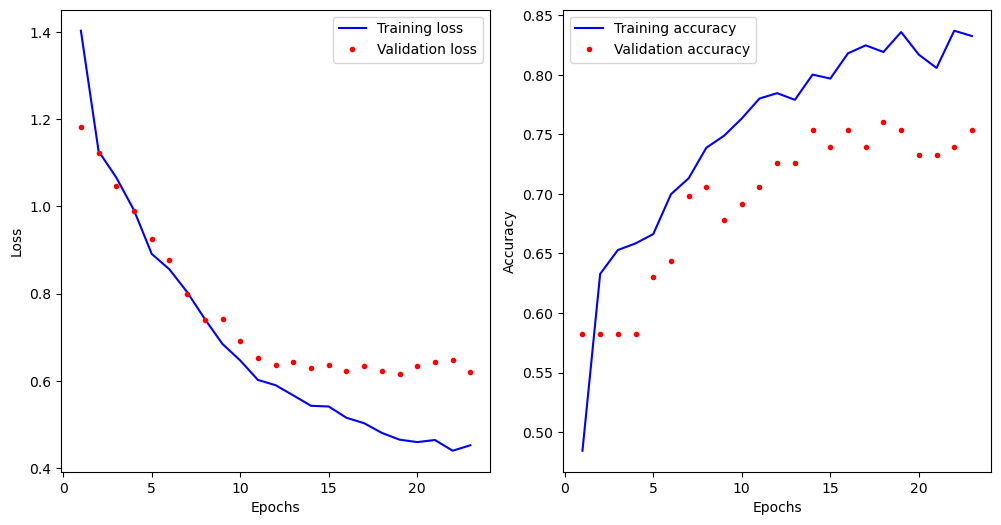

10/10 [==============================] - 0s 2ms/step - loss: 0.4920 - accuracy: 0.8157


In [10]:

#DRAW SOME GRAPHS
history_dict = history.history #keras (model.fit) automatically generates and returns a dictionary with metrics
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1,15)
ax1 = fig.add_subplot(gs[0:1, 0:7]) #first chart
ax2 = fig.add_subplot(gs[0:1, 8:15]) #second chart

ax1.plot(epochs, loss, "b", label="Training loss")
ax1.plot(epochs, val_loss, "r.", label="Validation loss")
ax2.plot(epochs, acc, "b", label="Training accuracy")
ax2.plot(epochs, val_acc, "r.", label="Validation accuracy")
ax1.set_xlabel("Epochs")
ax2.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")
ax1.legend()
ax2.legend()
plt.show()

#TEST
test_loss, test_acc = model.evaluate(X_test, y_test)

# DECISION TREES, RANDOM FORESTS, BOOSTING

We do not need to explicitly set aside validation data when using gridsearch, it already does crossvalidation for us. Hence we may fuse training and validation data.

In [11]:
#FUSE TRAINING AND VALIDATION DATA
X_train = X_shuffled[:num_train_samples + num_val_samples]
y_train = y_shuffled[:num_train_samples + num_val_samples]

## DECISION TREES

In [12]:
#build pipeline
trees = DecisionTreeClassifier(random_state=0)
pipe_dt = Pipeline([('trees', trees)])

param_grid_dt = {'trees__criterion': ['gini', 'entropy'],
                'trees__max_depth': [10, 12, 15, 17, 20]}

#GRID SEARCH
grid_dt = GridSearchCV(pipe_dt, param_grid=param_grid_dt, cv=5, n_jobs=-1)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trees',
                                        DecisionTreeClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'trees__criterion': ['gini', 'entropy'],
                         'trees__max_depth': [10, 12, 15, 17, 20]})

## RANDOM FOREST
Using balanced weights usually does worse
*We usually achieve a testing accuracy of 0.81 to 0.86*, depending on the random shuffling and splitting of test and training data.

In [13]:
#build pipeline
#class_weight='balanced_subsample', 
forest = RandomForestClassifier(random_state=0)
#forest = RandomForestClassifier(class_weight='balanced', random_state=0) #with balanced weights
pipe_rf = Pipeline([('forest', forest)]) 

param_grid_rf = {#'forest__criterion': ['gini', 'entropy', 'log_loss'],
    #'forest__min_samples_split': [2, 4, 6],
    #'forest__min_samples_leaf': [1, 2, 3, 4],
    #'forest__max_features': ['sqrt', 'log2'],
    'forest__max_depth': [10, 20, 30],
    'forest__n_estimators': [200, 300, 400, 500]}

#GRID SEARCH
grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('forest',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'forest__max_depth': [10, 20, 30],
                         'forest__n_estimators': [200, 300, 400, 500]})

## BOOSTED FORESTS

We tried three different boosting algorithms, all are just as good as plain random forest for this specific classification problem. Sometimes they outperform, depending on the random data shuffling. Overall we get similar performance to plain random forests. <br>
*We usually reach testing accuracies between 0.81 and 0.89.*

### The idea behind these boosting algorithms, _very_ quickly

'Boosting' essentially means combining small decision trees that each try to correct the errors of the previous one. For this purpose we compute a loss-function of one tree, compute or approximate its derivative (gradient), and then forge the next tree in such a way that the loss decreases as much as possible.

#### AdaBoost
- Trees have less depth, usually only 1 level.
- In random forests all trees have equal weight for the final classification, in adaboost some trees have more say than others.
- In random forests each tree is made independently from the others, in adaboost each tree takes into account the errors of the previous tree.

#### Gradient Boost
- Like AdaBoost, each tree is based on the errors the previous tree made.
- Trees usually have a low depth of around 5 or less, but more is possible too.


### Resources:
https://www.youtube.com/watch?v=LsK-xG1cLYA (adaboost)<br>
https://www.youtube.com/watch?v=TyvYZ26alZs (gradient boost, boosting)

In [14]:

#build pipeline
boost_ada = AdaBoostClassifier(estimator=forest, random_state=0)
boost_gb = GradientBoostingClassifier(init=forest, random_state=0)
pipe_ada = Pipeline([('boost_ada', boost_ada)])
pipe_gb = Pipeline([('boost_gb', boost_gb)]) 

param_grid_ada = {'boost_ada__n_estimators': [1, 2, 3],
                  'boost_ada__learning_rate': [0.00001, 0.0001, 0.001]}

param_grid_gb = {'boost_gb__n_estimators': [10, 20, 50, 100],
                'boost_gb__max_depth': [2, 4, 8],
                 'boost_gb__learning_rate': [0.001, 0.01, 0.1]}

#GRID SEARCH
grid_ada = GridSearchCV(pipe_ada, param_grid=param_grid_ada, cv=5, n_jobs=-1)
grid_ada.fit(X_train, y_train)
grid_gb = GridSearchCV(pipe_gb, param_grid=param_grid_gb, cv=5, n_jobs=-1)
grid_gb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('boost_gb',
                                        GradientBoostingClassifier(init=RandomForestClassifier(random_state=0),
                                                                   random_state=0))]),
             n_jobs=-1,
             param_grid={'boost_gb__learning_rate': [0.001, 0.01, 0.1],
                         'boost_gb__max_depth': [2, 4, 8],
                         'boost_gb__n_estimators': [10, 20, 50, 100]})

### FEATURE IMPORTANCE

In [15]:
feat_labels = data.columns[:-1]
importances = grid_rf.best_estimator_.named_steps["forest"].feature_importances_

indices = np.argsort(importances)[::-1]
n = X_train.shape[1]
for i in range(n):
    print('{0:2d}) {1:7s} {2:6.4f}'.format(i + 1, 
                                           feat_labels[indices[i]],
                                           importances[indices[i]]))

 1) GrLivArea 0.1113
 2) TotalBsmtSF 0.0909
 3) OverallQual 0.0740
 4) LotArea 0.0516
 5) AgeWhenSold 0.0493
 6) BsmtFinSF1 0.0469
 7) AgeSinceRemod 0.0418
 8) 2ndFlrSF 0.0413
 9) ExterQual 0.0385
10) KitchenQual 0.0342
11) BsmtQual 0.0338
12) GarageCars 0.0319
13) OverallCond 0.0233
14) FireplaceQu 0.0205
15) HeatingQC 0.0174
16) BedroomAbvGr 0.0164
17) MSSubClass_30.0 0.0081
18) MSSubClass_60.0 0.0081
19) Exterior1st_VinylSd 0.0071
20) Neighborhood_NridgHt 0.0070
21) HouseStyle_1Story 0.0066
22) RoofStyle_Gable 0.0064
23) LotConfig_Inside 0.0064
24) MSZoning_RL 0.0062
25) MoSold_5.0 0.0061
26) HouseStyle_2Story 0.0058
27) MSSubClass_20.0 0.0055
28) RoofStyle_Hip 0.0054
29) MoSold_7.0 0.0054
30) ExterCond 0.0053
31) MSZoning_RM 0.0052
32) SaleCondition_Normal 0.0052
33) Exterior1st_CemntBd 0.0051
34) BldgType_1Fam 0.0049
35) LotConfig_Corner 0.0049
36) Neighborhood_CollgCr 0.0048
37) SaleCondition_Normal 0.0047
38) MoSold_6.0 0.0046
39) SaleCondition_Partial 0.0043
40) MoSold_8.0 0.00

# MODEL COMPARISON

### What we noticed:

- When neural net is bad, decision trees are bad. When neural net is good, decision trees are also good.
- Random forest somewhere in the middle, mostly on par with boosted forests for this task.
- Boosted forests tend the perform best.

Confusion matrices look good. *Very little drastic misclassification*. If wrong, then only by one class, either one too high, or one too low. All models perform really well.

In [16]:
#CONFUSION MATRICES
y_pred_nn = model.predict(X_test)
y_pred_nn = np.argmax(y_pred_nn, axis=1)
y_pred_dt = grid_dt.best_estimator_.predict(X_test)
y_pred_rf = grid_rf.best_estimator_.predict(X_test)
y_pred_ada = grid_ada.best_estimator_.predict(X_test)
y_pred_gb = grid_gb.best_estimator_.predict(X_test)

print('\n----------------------------\nNEURAL NET:\n', confusion_matrix(y_test, y_pred_nn))
print("")
print(f"NN test loss: {round(test_loss,3)}")
print(f"NN test acc: {round(test_acc,3)}")
print('F1 score:', round(f1_score(y_test, y_pred_nn, average='weighted'),2))

print('\n----------------------------\nDECISION TREES:\n', confusion_matrix(y_test, y_pred_dt))
print("")
print('DT best CV acc: {:.3f}'.format(grid_dt.best_score_))
print('DT test acc:    {:.3f}'.format(grid_dt.score(X_test, y_test)))
print('DT best param:  {}'.format(grid_dt.best_params_))
print('F1 score:', round(f1_score(y_test, y_pred_dt, average='weighted'),2))


print('\n----------------------------\nRANDOM FOREST:\n', confusion_matrix(y_test, y_pred_rf))
print("")
print('RF best CV acc: {:.3f}'.format(grid_rf.best_score_))
print('RF test acc:    {:.3f}'.format(grid_rf.score(X_test, y_test)))
print('RF best param:  {}'.format(grid_rf.best_params_))
print('F1 score:', round(f1_score(y_test, y_pred_rf, average='weighted'),2))


print('\n----------------------------\nADABOOST:\n', confusion_matrix(y_test, y_pred_ada))
print("")
print('ADA best CV acc:  {:.3f}'.format(grid_ada.best_score_))
print('ADA test acc:     {:.3f}'.format(grid_ada.score(X_test, y_test)))
print('ADA best param:   {}'.format(grid_ada.best_params_))
print('F1 score:', round(f1_score(y_test, y_pred_ada, average='weighted'),2))


print('\n----------------------------\nGRADIENT BOOST:\n', confusion_matrix(y_test, y_pred_gb))
print("")
print('GB best CV acc:   {:.3f}'.format(grid_gb.best_score_))
print('GB test acc:      {:.3f}'.format(grid_gb.score(X_test, y_test)))
print('GB best param:    {}'.format(grid_gb.best_params_))
print('F1 score:', round(f1_score(y_test, y_pred_gb, average='weighted'),2))


10/10 [==============================] - 0s 2ms/step

----------------------------
NEURAL NET:
 [[  8   7   0   0   0]
 [  1 171  18   0   1]
 [  0  10  49   4   0]
 [  0   1   7   9   1]
 [  0   0   0   4   2]]

NN test loss: 0.492
NN test acc: 0.816
F1 score: 0.81

----------------------------
DECISION TREES:
 [[  9   6   0   0   0]
 [  9 170  11   0   1]
 [  0  13  48   2   0]
 [  0   0   8   9   1]
 [  0   0   0   3   3]]

DT best CV acc: 0.794
DT test acc:    0.816
DT best param:  {'trees__criterion': 'gini', 'trees__max_depth': 10}
F1 score: 0.82

----------------------------
RANDOM FOREST:
 [[  8   7   0   0   0]
 [  0 186   4   0   1]
 [  0  10  49   4   0]
 [  0   0   6  12   0]
 [  0   0   0   3   3]]

RF best CV acc: 0.829
RF test acc:    0.881
RF best param:  {'forest__max_depth': 20, 'forest__n_estimators': 400}
F1 score: 0.88

----------------------------
ADABOOST:
 [[  7   8   0   0   0]
 [  0 184   6   0   1]
 [  0  10  48   5   0]
 [  0   0   8  10   0]
 [  0   0   0  